In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Loading & Cleaning ---

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/final/medical_final_withId.csv')

In [ ]:
"""
# extra cleaning i haven't tried it yet :/
def clean_text(text): ...
df['tokenized_text'] = df['description'].apply(clean_text)
"""

"\n# extra cleaning i haven't tried it yet :/\ndef clean_text(text): ...\ndf['tokenized_text'] = df['description'].apply(clean_text)\n"

## Filtering out small classes (<90 entries):
treating class embalance;


### TODO:

  [ ] explore better strategies


In [ ]:
min_samples = 90
df = df.groupby('Specialty').filter(lambda x: len(x) >= min_samples)
print(f"Filtered dataset shape: {df.shape}")

Filtered dataset shape: (18587, 6)


# --- Embedding Generation (Basic 1 layer CLS) ---


### Remove any previously cached embeddings if they were generated on unfiltered data




In [ ]:
embedding_file = 'biobert_plain_embeddings.npy'
if os.path.exists(embedding_file):
    os.remove(embedding_file)
    print("Old cached embeddings removed.")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
texts = df['tokenized_text'].tolist()

## Load BioBERT with hidden states


In [ ]:
model_name = 'pritamdeka/S-PubMedBert-MS-MARCO'
sbert_model = SentenceTransformer(model_name)
sbert_model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/388 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/461k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 350, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

## ENcoding embeddings




In [ ]:
print("Encoding texts with SBERT...")
embeddings_sbert = sbert_model.encode(
    texts,
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True,
    device=device
)


Encoding texts with SBERT...


Batches:   0%|          | 0/581 [00:00<?, ?it/s]

Generated embeddings shape: (18587, 768)


## Saving the generated embeddings:

In [ ]:
print(f"Generated embeddings shape: {embeddings_sbert.shape}")
np.save('embeddings_sbert.npy', embeddings_sbert)

Generated embeddings shape: (18587, 768)


# Train/Validation/Test split

In [ ]:
label_encoder = LabelEncoder()
df['y'] = label_encoder.fit_transform(df['Specialty'])

X_train_val, X_test, y_train_val, y_test = train_test_split(
    embeddings_sbert, df['y'], test_size=0.2, random_state=42, stratify=df['y']
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (11151, 768), Val: (3718, 768), Test: (3718, 768)


# The classifier

## COnstruction

In [ ]:
input_dim = X_train.shape[1]
num_classes = len(label_encoder.classes_)

model_tf = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model_tf.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_tf.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 563,858 (2.15 MB)

 Trainable params: 562,066 (2.14 MB)

 Non-trainable params: 1,792 (7.00 KB)

## Training

In [ ]:
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint('best_medical_classifier_sbert.keras', monitor='val_accuracy', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

history = model_tf.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_list
)

Epoch 1/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.6056 - loss: 1.4114 - val_accuracy: 0.7655 - val_loss: 0.7530 - learning_rate: 0.0010
Epoch 2/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7481 - loss: 0.8255 - val_accuracy: 0.7751 - val_loss: 0.6993 - learning_rate: 0.0010
Epoch 3/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7608 - loss: 0.7561 - val_accuracy: 0.7800 - val_loss: 0.7026 - learning_rate: 0.0010
Epoch 4/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7716 - loss: 0.7237 - val_accuracy: 0.7786 - val_loss: 0.6872 - learning_rate: 0.0010
Epoch 5/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7760 - loss: 0.6965 - val_accuracy: 0.7800 - val_loss: 0.6907 - learning_rate: 0.0010
Epoch 6/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7849 - loss: 0.6712 - val_accuracy: 0.7883 - val_loss: 0.6861 - learning_rate: 0.0010
Epoch 7/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7774 - loss: 0.6687 

# --- Evaluation ---


Methode(s): we're calculating the accuracy / using a confusion matrix

In [ ]:
test_loss, test_acc = model_tf.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}, loss: {test_loss:.4f}")

Test accuracy: 0.7864, loss: 0.6757


In [ ]:
y_pred = np.argmax(model_tf.predict(X_test), axis=1)
target_names = label_encoder.classes_
print(classification_report(y_test, y_pred, target_names=target_names))

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
                                  precision    recall  f1-score   support

                      Cardiology       0.71      0.86      0.78        90
                       Dentistry       0.86      0.93      0.90       136
                     Dermatology       0.72      0.82      0.77       254
             ENT and Pulmonology       0.59      0.68      0.63        75
                   Endocrinology       0.61      0.51      0.56        49
                 Family Medicine       0.96      0.78      0.86       356
                Gastroenterology       0.46      0.40      0.42        43
                General Medicine       0.76      0.73      0.74       455
               Internal Medicine       0.35      0.28      0.31       318
                       Neurology       0.80      0.88      0.84       247
       Obstetrics and Gynecology       0.92      0.96      0.94       926
                   Ophthalmology       0.85      0.94      0.90       

### *Confusion matrix fuss*

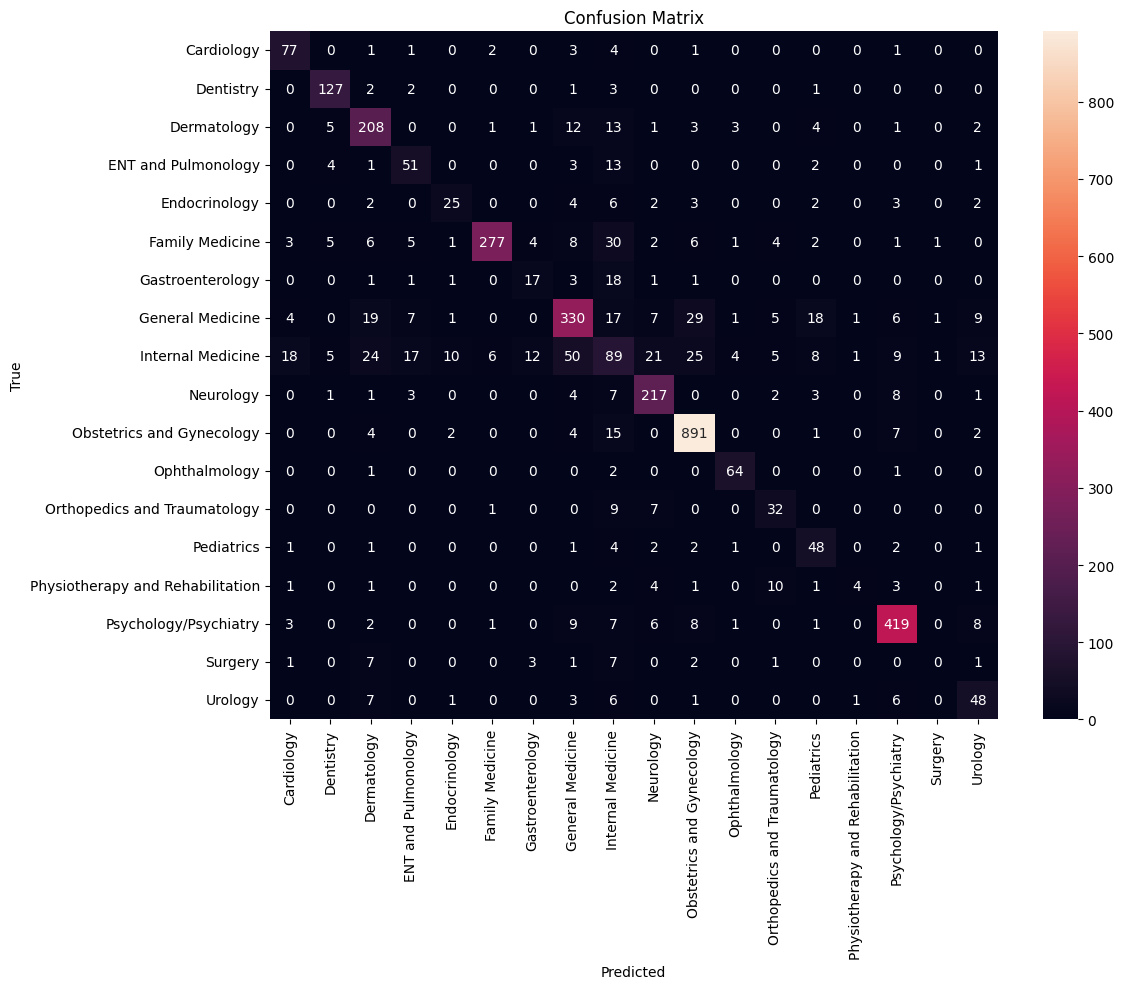

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

<span style="color: red; font-weight: bold">
  This text is bold blue.
</span>

In [ ]:
!mkdir drive/MyDrive/noyauS

In [ ]:
!cp embeddings_sbert.npy drive/MyDrive/noyauS

In [ ]:
!cp best_medical_classifier_sbert.keras drive/MyDrive/noyau2